# 4.2 Supervised Learning with Random Forest

In [50]:
import os
import sys
import re
import csv
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve

## Load image paths from google drive. To use the local files, change `google_path` to `.`

In [51]:
google_path = '/content/drive/MyDrive'
path = os.path.join(google_path, 'QC')
train_test_path = os.path.join(path, 'split')
mask_path = os.path.join(path, "mask")
rgb_path = os.path.join(path, "rgb")

# Load training and validation csv files
def load_subjects(csv_path):
    with open(csv_path, newline='') as f:
        reader = csv.reader(f)
        subjects = list(reader)
    return subjects[1:]

train_subjects = load_subjects(os.path.join(train_test_path, 'train_subjects.csv'))
val_subjects = load_subjects(os.path.join(train_test_path, 'validate_subjects.csv'))

## Load images and masks； Extract and downsample pixels

In [52]:
# Match images with the labels in the csv file
def get_image_mask_pairs(subjects):
    images = []
    masks = []
    for patient in subjects:
        for file in os.listdir(rgb_path):
            if re.match(patient[0], file):
                images.append(os.path.join(rgb_path, file))
                masks.append(os.path.join(mask_path, file))
    return images, masks

train_images, train_masks = get_image_mask_pairs(train_subjects)
val_images, val_masks = get_image_mask_pairs(val_subjects)


# Load and preprocess images and masks
def load_and_preprocess(rgb_path, mask_path, target_size=(256, 256), threshold_value=5):

    img = cv.imread(rgb_path, cv.IMREAD_GRAYSCALE)
    img_resized = cv.resize(img, target_size)

    mask_color = cv.imread(mask_path, cv.IMREAD_COLOR)
    mask_resized = cv.resize(mask_color, target_size)
    mask_channel = mask_resized[:, :, 0]
    _, mask_bin = cv.threshold(mask_channel, threshold_value, 255, cv.THRESH_BINARY)
    mask_bin = (mask_bin // 255).astype(np.uint8)

    img_flat = img_resized.flatten().reshape(-1, 1)
    mask_flat = mask_bin.flatten()
    return img_flat, mask_flat, img_resized, mask_bin


def extract_downsampled_pixel_labels(images, masks, target_size=(256,256), sample_fraction=0.05, threshold_value=5):

    X_list, Y_list = [], []

    for img_path, mask_path in zip(images, masks):
        # Use preprocessed images
        img_flat, mask_flat, _, _ = load_and_preprocess(img_path, mask_path, target_size, threshold_value)

        # Randomly sample pixels
        num_pixels = len(img_flat)
        sample_size = int(num_pixels * sample_fraction)
        indices = np.random.choice(num_pixels, sample_size, replace=False)

        X_list.append(img_flat[indices])
        Y_list.append(mask_flat[indices])

    # Concatenate all samples into one dataset
    X_down = np.concatenate(X_list).reshape(-1, 1)
    Y_down = np.concatenate(Y_list)
    return X_down, Y_down

## Train the random forest model

In [53]:
X_down_train, Y_down_train = extract_downsampled_pixel_labels(train_images, train_masks, sample_fraction=0.05)
X_down_val, Y_down_val = extract_downsampled_pixel_labels(val_images, val_masks, sample_fraction=0.05)

# Apply a max depth to avoid the overfitting
clf_down = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1, max_depth=30)
clf_down.fit(X_down_train, Y_down_train)

Y_down_train_pred = clf_down.predict(X_down_train)
Y_down_val_pred = clf_down.predict(X_down_val)

## Evaluate the model with ACC, AUC and other metrics

Training Accuracy: 0.789537574369035
Training AUC: 0.7653659374258358
Training Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.94      0.87   3322294
           1       0.62      0.32      0.42   1051166

    accuracy                           0.79   4373460
   macro avg       0.72      0.63      0.65   4373460
weighted avg       0.77      0.79      0.76   4373460

Validation Accuracy: 0.7863270253245803
Validation AUC: 0.7877635263872597
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.95      0.87   1015030
           1       0.64      0.27      0.38    324854

    accuracy                           0.79   1339884
   macro avg       0.72      0.61      0.63   1339884
weighted avg       0.76      0.79      0.75   1339884



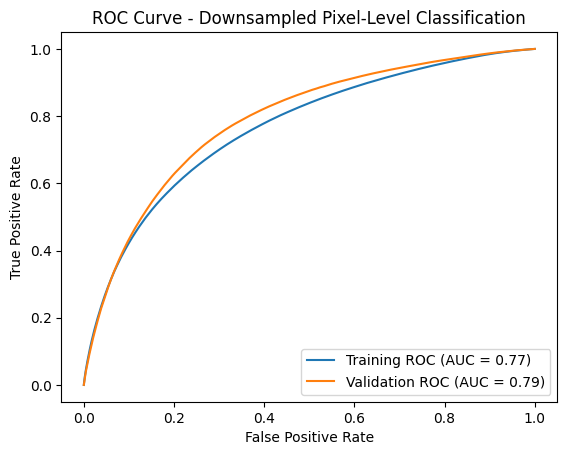

In [55]:
# Compute predicted probabilities for patch-based classifier
print("Training Accuracy:", accuracy_score(Y_down_train, Y_down_train_pred))
print("Training AUC:", roc_auc_score(Y_down_train, clf_down.predict_proba(X_down_train)[:, 1]))
print("Training Classification Report:")
print(classification_report(Y_down_train, Y_down_train_pred, zero_division=0))
print("Validation Accuracy:", accuracy_score(Y_down_val, Y_down_val_pred))
print("Validation AUC:", roc_auc_score(Y_down_val, clf_down.predict_proba(X_down_val)[:, 1]))
print("Validation Classification Report:")
print(classification_report(Y_down_val, Y_down_val_pred, zero_division=0))

# Plot ROC Curves
fpr_train, tpr_train, _ = roc_curve(Y_down_train, clf_down.predict_proba(X_down_train)[:, 1])
fpr_val, tpr_val, _ = roc_curve(Y_down_val, clf_down.predict_proba(X_down_val)[:, 1])

plt.figure()
plt.plot(fpr_train, tpr_train, label=f'Training ROC (AUC = {roc_auc_score(Y_down_train, clf_down.predict_proba(X_down_train)[:,1]):.2f})')
plt.plot(fpr_val, tpr_val, label=f'Validation ROC (AUC = {roc_auc_score(Y_down_val, clf_down.predict_proba(X_down_val)[:,1]):.2f})')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Downsampled Pixel-Level Classification")
plt.legend(loc="lower right")
plt.show()

## Show sample images

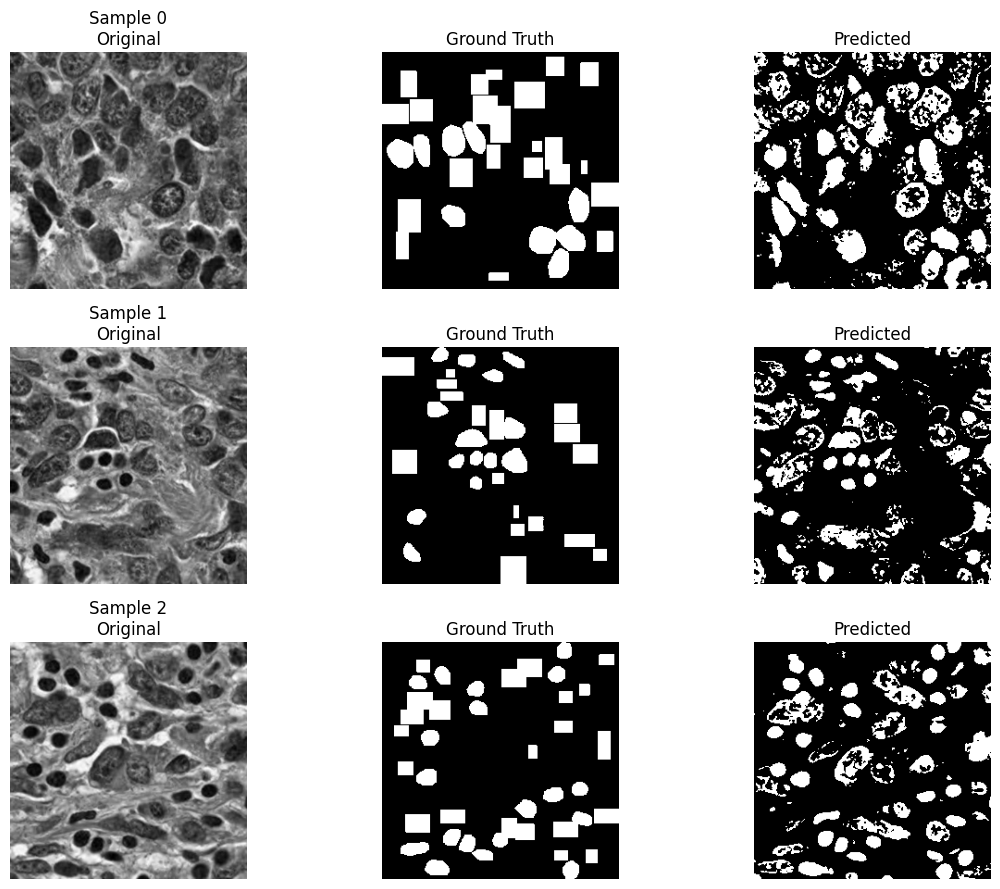

In [56]:
def predict_mask_from_image(image_path, model, target_size=(256,256)):

    # Read the image and resize it
    img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    img_resized = cv.resize(img, target_size)
    X = img_resized.flatten().reshape(-1, 1)

    # Predict labels (0 or 1) for each pixel
    y_pred = model.predict(X)
    # Reshape predictions to the original image dimensions
    mask_pred = y_pred.reshape(target_size)
    mask_pred_vis = (mask_pred * 255).astype(np.uint8)
    return mask_pred_vis

def get_ground_truth_mask(mask_path, target_size=(256,256), threshold_value=10):

    mask_color = cv.imread(mask_path, cv.IMREAD_COLOR)
    mask_resized = cv.resize(mask_color, target_size)

    mask_channel = mask_resized[:, :, 0]
    # Apply the manual threshold
    _, mask_bin = cv.threshold(mask_channel, threshold_value, 255, cv.THRESH_BINARY)
    return mask_bin

# Define a list of sample indices to display (for example, 5 images)
sample_indices = [0, 1, 2]

# Set target image size for display
target_size = (256, 256)

# Create a figure with 5 rows and 3 columns: Original, Ground Truth, and Predicted
num_samples = len(sample_indices)
plt.figure(figsize=(12, 3*num_samples))

for idx, sample_index in enumerate(sample_indices):
    image_path = train_images[sample_index]
    mask_path = train_masks[sample_index]

    # Predict the mask using the trained classifier (clf_down)
    pred_mask = predict_mask_from_image(image_path, clf_down, target_size=target_size)
    # Get the ground truth binary mask using the threshold method
    gt_mask = get_ground_truth_mask(mask_path, target_size=target_size, threshold_value=10)
    # Read and resize the original image for display
    orig_img = cv.imread(image_path, cv.IMREAD_GRAYSCALE)
    orig_img_resized = cv.resize(orig_img, target_size)

    # Plot the original image, ground truth mask, and predicted mask in one row
    plt.subplot(num_samples, 3, idx*3 + 1)
    plt.imshow(orig_img_resized, cmap='gray')
    plt.title(f"Sample {sample_index}\nOriginal")
    plt.axis("off")

    plt.subplot(num_samples, 3, idx*3 + 2)
    plt.imshow(gt_mask, cmap='gray')
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(num_samples, 3, idx*3 + 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Predicted")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Dice score computation

In [57]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Dice coefficient between two binary masks
def dice_coefficient(y_true, y_pred):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)
    intersection = np.logical_and(y_true, y_pred).sum()
    total = y_true.sum() + y_pred.sum()
    if total == 0:  # avoid division by zero
        return 1.0
    return 2 * intersection / total

# Evaluate dice per image
def evaluate_dice_per_image(model, images, masks, target_size=(256, 256), sample_fraction=1.0, threshold_value=10):
    dice_scores = []
    filenames = []
    predictions = []

    for img_path, mask_path in zip(images, masks):
        # Use preprocessing function
        img_flat, mask_flat, img_resized, mask_resized = load_and_preprocess(
            img_path, mask_path, target_size, threshold_value
        )

        # Sample pixels
        num_pixels = len(img_flat)
        sample_size = int(num_pixels * sample_fraction)
        indices = np.random.choice(num_pixels, sample_size, replace=False)

        X_sampled = img_flat[indices]
        Y_true_sampled = mask_flat[indices]

        Y_pred_sampled = model.predict(X_sampled)
        Y_pred_bin = (Y_pred_sampled > 0.5).astype(np.uint8)

        dice = dice_coefficient(Y_true_sampled, Y_pred_bin)

        # Full prediction for visualization
        full_pred = model.predict(img_flat)
        full_pred_bin = (full_pred > 0.5).astype(np.uint8).reshape(target_size)

        dice_scores.append(dice)
        filenames.append(os.path.basename(img_path))
        predictions.append(full_pred_bin)

    return filenames, dice_scores, predictions



## Visualization of the dice score

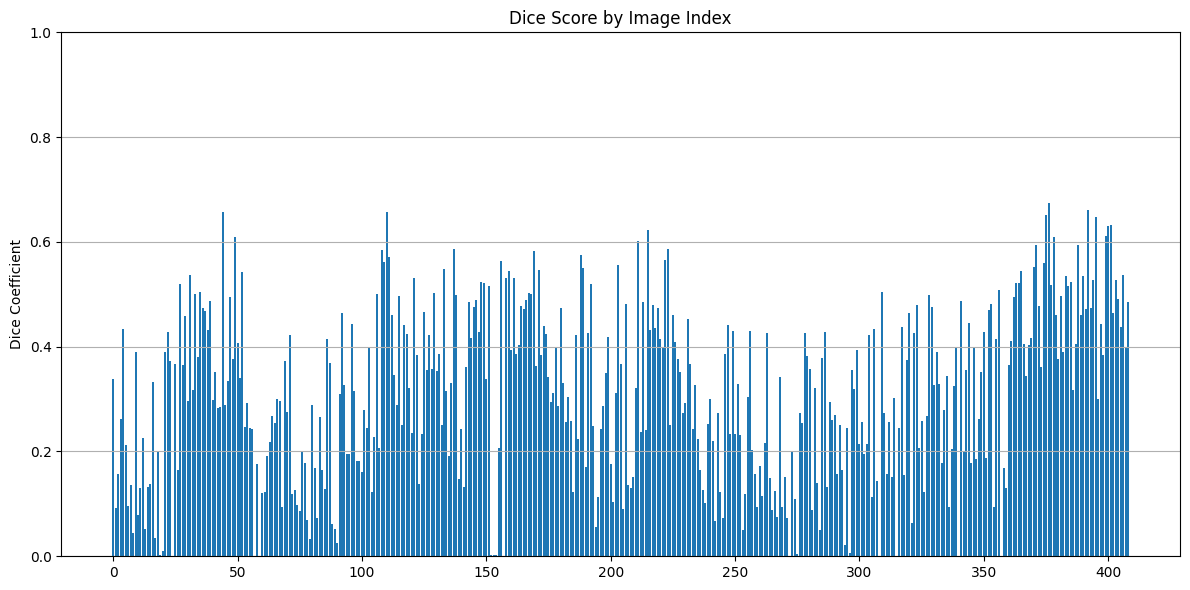

In [58]:
filenames, dice_scores, preds = evaluate_dice_per_image(clf_down, val_images, val_masks)

plt.figure(figsize=(12, 6))
plt.bar(range(len(dice_scores)), dice_scores)
plt.ylabel("Dice Coefficient")
plt.title("Dice Score by Image Index")
plt.ylim(0, 1)
plt.tight_layout()
plt.grid(axis='y')
plt.show()


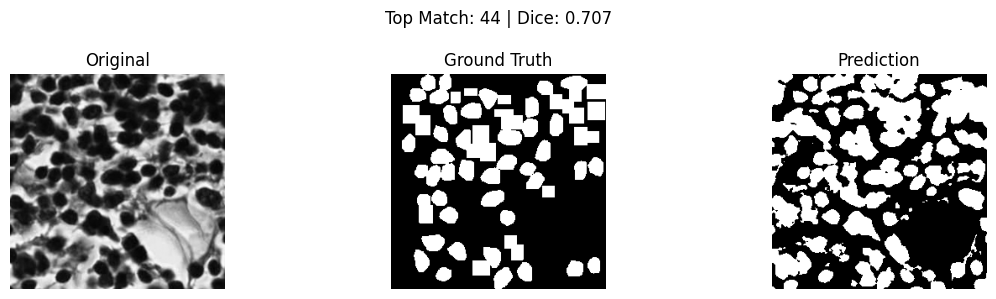

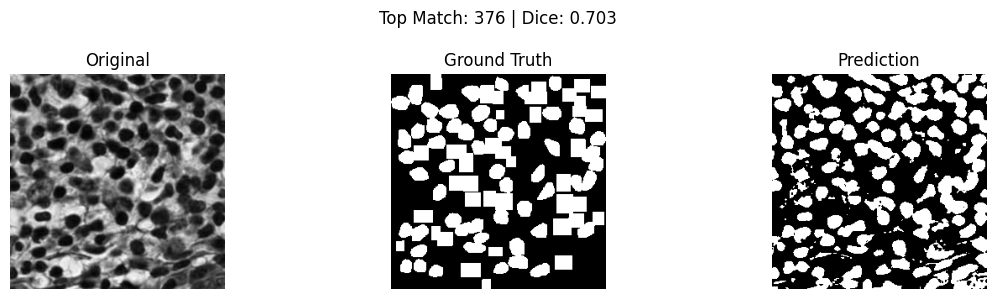

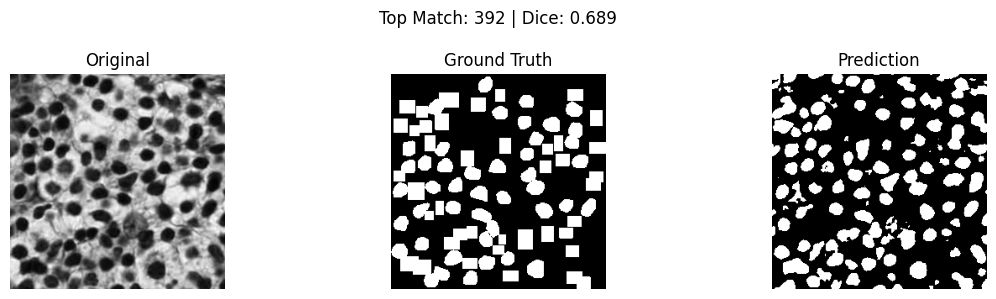

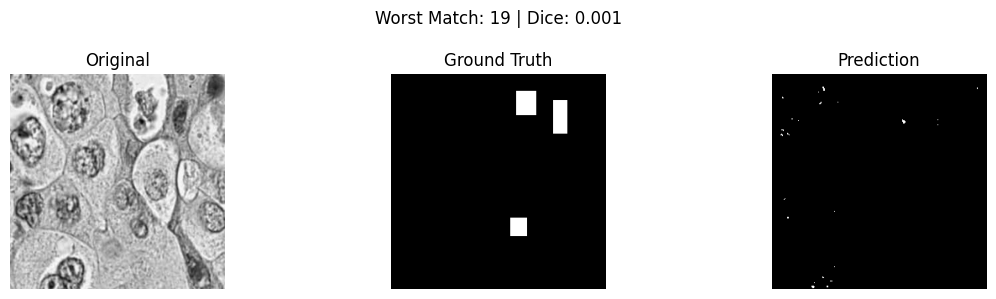

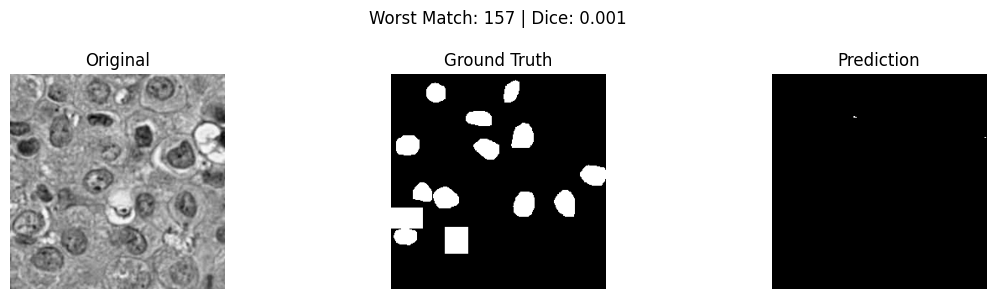

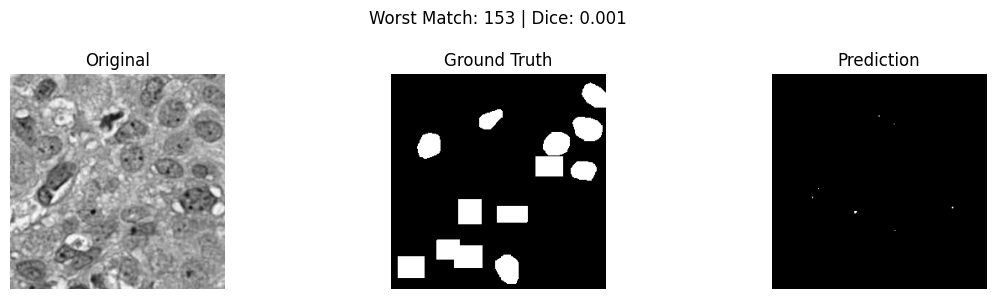

In [59]:
filenames = []
dice_scores = []
preds = []

# Loop through validation images
for img_path, mask_path in zip(val_images, val_masks):
    img_flat, mask_flat, img_resized, mask_bin = load_and_preprocess(img_path, mask_path, target_size=(256, 256), threshold_value=5)

    pred_flat = clf_down.predict(img_flat)
    pred_bin = (pred_flat > 0.5).astype(np.uint8).reshape(256, 256)

    intersection = np.logical_and(mask_flat, pred_flat).sum()
    total = mask_flat.sum() + pred_flat.sum()
    dice = 2 * intersection / total if total != 0 else 1.0

    filenames.append(img_path)
    dice_scores.append(dice)
    preds.append(pred_bin)

# Get best and worst 3 indices
sorted_indices = np.argsort(dice_scores)
lowest_indices = sorted_indices[:3]
highest_indices = sorted_indices[-3:]

# Display images (top 3 best and bottom 3 worst)
for idx in list(highest_indices[::-1]) + list(lowest_indices):
    _, _, img_resized, mask_bin = load_and_preprocess(val_images[idx], val_masks[idx], target_size=(256, 256), threshold_value=10)
    pred = preds[idx]

    plt.figure(figsize=(12, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(img_resized, cmap='gray')
    plt.title("Original")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(mask_bin, cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred, cmap='gray')
    plt.title("Prediction")
    plt.axis('off')

    label = "Top Match" if idx in highest_indices else "Worst Match"
    plt.suptitle(f"{label}: {idx} | Dice: {dice_scores[idx]:.3f}")
    plt.tight_layout()
    plt.show()